# Create NBA Player Shot Charts with Python 
## Part 1

This post is the first in a series that demonstrate how to make shot charts by combining the Python module [`nba_api`](https://github.com/swar/nba_api) with the visualization modules `matplotlib` and `seaborn`. 

## Overview
* Background
* Data Collection
* Data Visualization
* Review
* References

## Background
In 2012, at the $6^{th}$ annual [Sloan Sports Conference](https://www.sloansportsconference.com/) at MIT, geographer and basketball enthusiast Kirk Goldsberry unveiled the shot chart and [revolutionized](https://www.cnn.com/2014/11/04/business/revolutionizing-basketball-with-data/index.html) basketball analytics with his paper *[CourtVision: New Visual and Spatial Analytics for the NBA](https://web.archive.org/web/20130819100141/http://www.sloansportsconference.com:80/wp-content/uploads/2012/02/Goldsberry_Sloan_Submission.pdf)*. Goldsberry's shot chart (Figure 1, shown below) is a heatmap visual representation of the location, frequency, and accuracy of a player's shot performance. The key intution behind shot charts is that spatial analytics provide more player insight than traditional boxscore numbers like field goal percentage. Shot charts provide insights into player tendencies (where they shoot, how successful), allow for comparison between players, and provide a a sense of what players complement each other based on location preferences/style of play. Goldsberry's spatial analytics along with [John Hollinger's PER](https://en.wikipedia.org/wiki/Player_efficiency_rating) were part of the first wave of advanced analytics being introduced to basketball and represent the dawn of basketball's "[Moneyball](https://www.amazon.com/Moneyball-Art-Winning-Unfair-Game/dp/0393324818)" era where basketball front office's started to seriously use advanced analytics in decision making.

NBA teams were so impressed by spatial analytics that the league partnered with [SportVU](https://www.statsperform.com/team-performance/football-performance/optical-tracking/) and then [Second Spectrum](https://www.secondspectrum.com/index.html) to track player movement for the entire league. 
Teams like the Los Angeles [Clippers have invested](https://www.sportspromedia.com/news/la-clippers-amazon-courtvision-nba-artificial-intelligence/) even more in spatial analytics and have started to leverage artificial intelligence to analyze player and team performance. This post repurposes code from indivudual and collaborative work by [Savvas Tjortjoglou](http://savvastjortjoglou.com/nba-shot-sharts.html) and Bradley Fay, key contributors to Python's [py-Goldsberry](https://github.com/bradleyfay/py-Goldsberry/) module (created and maintained by Bradley Fay). See the References section for links to code by these authors



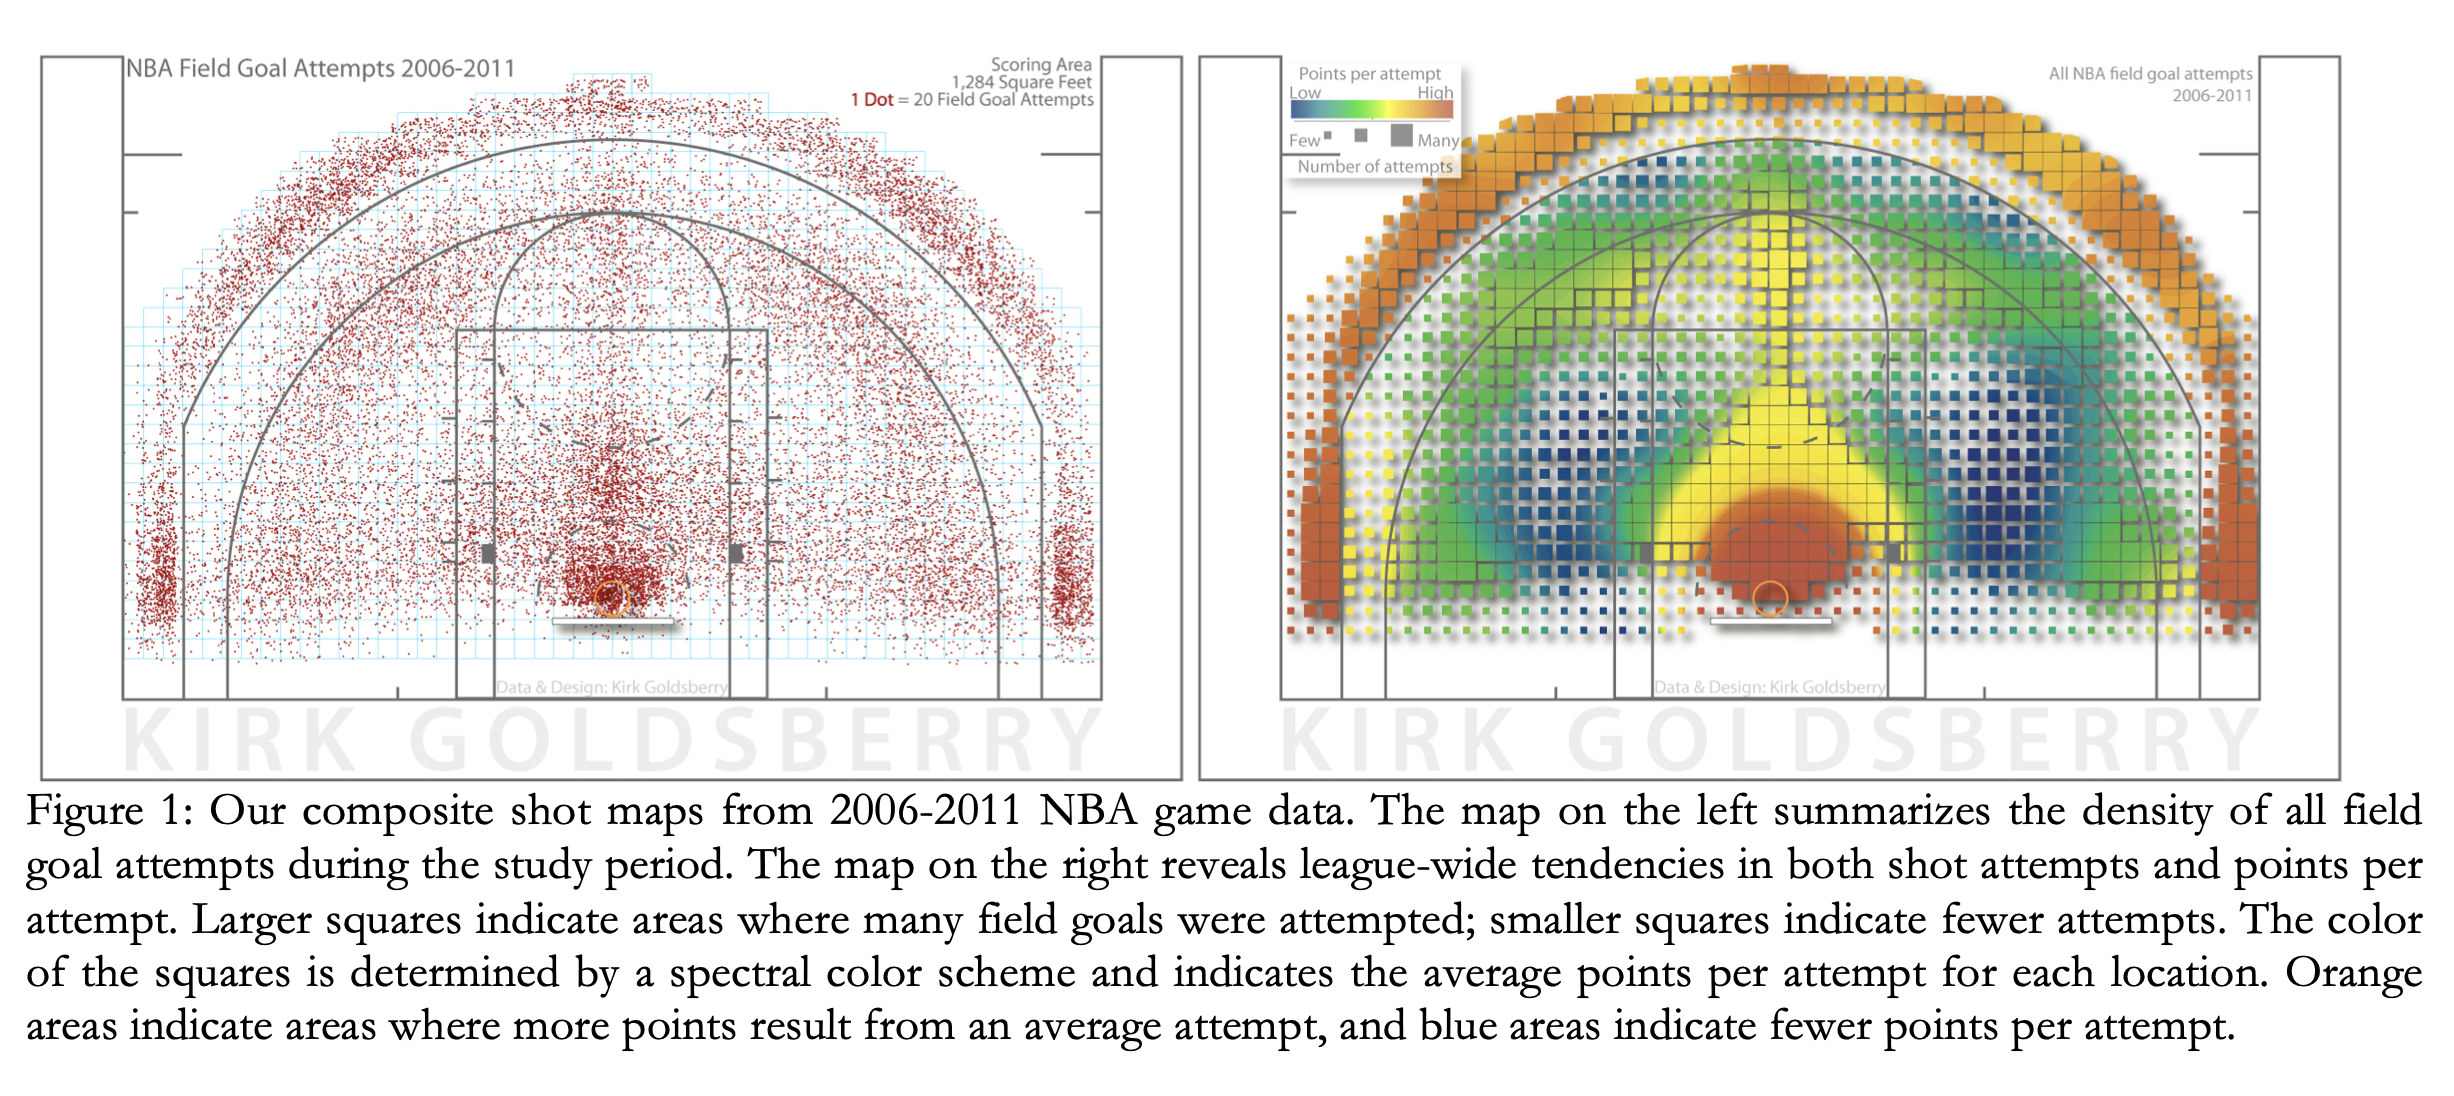

In [1]:

import base64, io, IPython
from PIL import Image as PILImage

image_path = "goldsberry_2012_figure_1.png"
image = PILImage.open(image_path)

output = io.BytesIO()
image.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

## Data Collection

To make Goldsberry's shot charts and use spatial analytics, we first need to get the player location data that is compiled by NBA partner Second Spectrum. The NBA makes this data available for consumption through an API (Application Programming Interface) and a group of Python developers created a module, [`nba_api`](https://github.com/swar/nba_api), to leverage the NBA's API. One of the API endpoints wrapped in the `nba_api` module is the Shot Chart endpoint. This endpoint provides a `shotchartdetail` DataFrame with the X and Y coordinates for all shots taken by a given player.

In [2]:
from nba_api.stats.static import players, teams
from nba_api.stats.endpoints import shotchartdetail
from matplotlib.offsetbox import OffsetImage
import matplotlib.gridspec as gridspec
from IPython.display import display
from typing import List, Dict
from utils import draw_court, create_joint_shot_chart, SeabornFig2Grid
import matplotlib.pyplot as plt
import urllib
import pandas as pd
import numpy as np
import seaborn as sns
import json

###  Gathering the Data
We can use the `nba_api` module to create databases of teams and players. Once we have these databases, we can filter along individuals or teams to make shot charts

In [3]:
players_dict = players.get_players()
teams_dict = teams.get_teams()

In [4]:
total_players = len([player for player in players_dict])
total_teams = len([team for team in teams_dict])
print(f"there are {total_players} in the players database and {total_teams} in the teams database")

there are 4723 in the players database and 30 in the teams database


the `players` submodule from the `nba_api` module has a function, `find_players_by_full_name`, that we can use to get the player dictionary information for a given player. the function returns a list that we can take the first element from to create the player dictionary. let's use the `find_players_by_full_name` function to filter the players submodule (a list of player dictionaries), for Kobe Bryant's information and then explore the player dictionary

In [5]:
kobe_bryant_dict = players.find_players_by_full_name('kobe bryant')[0]
kobe_bryant_dict

{'id': 977,
 'full_name': 'Kobe Bryant',
 'first_name': 'Kobe',
 'last_name': 'Bryant',
 'is_active': False}

similar to the `find_players_by_full_name` function from the `players` submodule, the `teams` submodule has a function  `find_teams_by_nickname` that allows us to filter the `teams` submodule database of teams to get information on a team by using their nickanme. let's use the `find_teams_by_nickname` to get information for Kobe's lifelong team, the Los Angeles Lakers

In [6]:
lakers_dict = teams.find_teams_by_nickname('lakers')[0]
lakers_dict

{'id': 1610612747,
 'full_name': 'Los Angeles Lakers',
 'abbreviation': 'LAL',
 'nickname': 'Lakers',
 'city': 'Los Angeles',
 'state': 'California',
 'year_founded': 1948}

now we can use the `id` field from the player dictionary to get player location data. we'll start out with a player location data for an entire year, but shot chart data can be gathered for an individual game. We'll use Kobe Bryant's player `id` (977) and team `id` (1610612747) to gather the location of all shots from two seasons in Kobe Bryant's career: his [2007-2008 MVP season](http://www.espn.com/espn/wire/_/section/nba/id/3384506) and final season in [2015-2016](https://www.nba.com/news/lakers-kobe-bryant-final-season-documented-all-access) with the [`shotchartdetail`](https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/shotchartdetail.md) function. `shotchartdetail` makes a call to the shot chart endpoint with the parameters supplied in the function

* Kobe's 2007-2008 shot chart data from NBA API

In [7]:
kobe_shot_chart_2008_response = shotchartdetail.ShotChartDetail(
    team_id=lakers_dict.get("id"),
    player_id=kobe_bryant_dict.get("id"),
    season_nullable='2007-08',
    season_type_all_star='Regular Season',
    context_measure_simple='FGA'
)

kobe_shot_chart_2008_content = json.loads(kobe_shot_chart_2008_response.get_json())

* Kobe's 2015-2016 shot chart data from NBA API

In [8]:
kobe_shot_chart_2016_response = shotchartdetail.ShotChartDetail(
    team_id=lakers_dict.get("id"),
    player_id=kobe_bryant_dict.get("id"),
    season_nullable='2015-16',
    season_type_all_star='Regular Season',
    context_measure_simple='FGA'
)

kobe_shot_chart_2016_content = json.loads(kobe_shot_chart_2016_response.get_json())

in the next post, we'll make a function to leverage the leaguegamefinder endpoint to get individual game ids for shot chart creation on the game-level instead of the season-lvel. right now, let's examine the data provided by the shot chart endpoint. The dictionary from the API response has three keys, and the X and Y coordinate data is in the `resultSets` dictionary

In [9]:
kobe_shot_chart_2008_content.keys()

dict_keys(['resource', 'parameters', 'resultSets'])

in the `resultsSets` dictionary we see the fields `LOC_X` and `LOC_Y` which are the X and Y coordinates of the player's shot

In [10]:
kobe_shot_chart_2008_content.get("resultSets")[0].get("headers")

['GRID_TYPE',
 'GAME_ID',
 'GAME_EVENT_ID',
 'PLAYER_ID',
 'PLAYER_NAME',
 'TEAM_ID',
 'TEAM_NAME',
 'PERIOD',
 'MINUTES_REMAINING',
 'SECONDS_REMAINING',
 'EVENT_TYPE',
 'ACTION_TYPE',
 'SHOT_TYPE',
 'SHOT_ZONE_BASIC',
 'SHOT_ZONE_AREA',
 'SHOT_ZONE_RANGE',
 'SHOT_DISTANCE',
 'LOC_X',
 'LOC_Y',
 'SHOT_ATTEMPTED_FLAG',
 'SHOT_MADE_FLAG',
 'GAME_DATE',
 'HTM',
 'VTM']

we can convert the `resultSets` dictionary into a DataFrame to aid in analysis

In [11]:
headers = kobe_shot_chart_2008_content['resultSets'][0]['headers']
# Grab the shot chart data
kobe_2008_shots = kobe_shot_chart_2008_content['resultSets'][0]['rowSet']
# combine shot chart data and headers into a DataFrame
kobe_2008_shots_df = pd.DataFrame(kobe_2008_shots, columns=headers)
# View the head of the DataFrame and all its columns
with pd.option_context('display.max_columns', None):
    display(kobe_2008_shots_df.head())

GRID_TYPE     GAME_ID  GAME_EVENT_ID  PLAYER_ID  PLAYER_NAME  \
0  Shot Chart Detail  0020700002              4        977  Kobe Bryant   
1  Shot Chart Detail  0020700002             19        977  Kobe Bryant   
2  Shot Chart Detail  0020700002             23        977  Kobe Bryant   
3  Shot Chart Detail  0020700002             31        977  Kobe Bryant   
4  Shot Chart Detail  0020700002             48        977  Kobe Bryant   

      TEAM_ID           TEAM_NAME  PERIOD  MINUTES_REMAINING  \
0  1610612747  Los Angeles Lakers       1                 11   
1  1610612747  Los Angeles Lakers       1                  9   
2  1610612747  Los Angeles Lakers       1                  9   
3  1610612747  Los Angeles Lakers       1                  7   
4  1610612747  Los Angeles Lakers       1                  6   

   SECONDS_REMAINING   EVENT_TYPE ACTION_TYPE       SHOT_TYPE  \
0                 29  Missed Shot   Jump Shot  2PT Field Goal   
1                 19  Missed Shot  Layup Shot  2PT Field Goal   
2                  1    Made Shot  Layup Shot  2PT Field Goal   
3                 56    Made Shot   Jump Shot  2PT Field Goal   
4                  6  Missed Shot   Jump Shot  3PT Field Goal   

     SHOT_ZONE_BASIC         SHOT_ZONE_AREA  SHOT_ZONE_RANGE  SHOT_DISTANCE  \
0          Mid-Range              Center(C)        16-24 ft.             21   
1    Restricted Area              Center(C)  Less Than 8 ft.              0   
2    Restricted Area              Center(C)  Less Than 8 ft.              0   
3          Mid-Range              Center(C)        16-24 ft.             20   
4  Above the Break 3  Right Side Center(RC)          24+ ft.             26   

   LOC_X  LOC_Y  SHOT_ATTEMPTED_FLAG  SHOT_MADE_FLAG GAME_DATE  HTM  VTM  
0     54    209                    1               0  20071030  LAL  HOU  
1      0      0                    1               0  20071030  LAL  HOU  
2      0      0                    1               1  20071030  LAL  HOU  
3     51    201                    1               1  20071030  LAL  HOU  
4    121    237                    1               0  20071030  LAL  HOU

In [12]:
kobe_2016_shots = kobe_shot_chart_2016_content['resultSets'][0]['rowSet']
# combine shot chart data and headers into a DataFrame
kobe_2016_shots_df = pd.DataFrame(kobe_2016_shots, columns=headers)

* `get_shots_df_by_season` collapses the last few lines of code into a function to create a shot dataframe. the function takes the following parameters
    + `team_dict`
    + `player_dict`
    + `season`
* let's get kobe's rookie season shot dataframe with this functon 

In [13]:
def get_shots_df_by_season(team_dict: Dict, player_dict: Dict, season: str):
    """
    """
    shot_chart_response = shotchartdetail.ShotChartDetail(
    team_id=team_dict.get("id"),
    player_id=player_dict.get("id"),
    season_nullable=season,
    season_type_all_star='Regular Season',
    context_measure_simple='FGA'
    )

    shot_chart_content = json.loads(shot_chart_response.get_json())
    headers = shot_chart_content['resultSets'][0]['headers']
    # Grab the shot chart data
    shots = shot_chart_content['resultSets'][0]['rowSet']
    # combine shot chart data and headers into a DataFrame
    shots_df_by_season = pd.DataFrame(shots, columns=headers)
    return(shots_df_by_season)

In [14]:
kobe_1996_shots_df = get_shots_df_by_season(lakers_dict, kobe_bryant_dict, "1996-97")
kobe_1996_shots_df.head()

GRID_TYPE     GAME_ID  GAME_EVENT_ID  PLAYER_ID  PLAYER_NAME  \
0  Shot Chart Detail  0029600027            102        977  Kobe Bryant   
1  Shot Chart Detail  0029600031            127        977  Kobe Bryant   
2  Shot Chart Detail  0029600044            124        977  Kobe Bryant   
3  Shot Chart Detail  0029600044            144        977  Kobe Bryant   
4  Shot Chart Detail  0029600044            151        977  Kobe Bryant   

      TEAM_ID           TEAM_NAME  PERIOD  MINUTES_REMAINING  \
0  1610612747  Los Angeles Lakers       1                  0   
1  1610612747  Los Angeles Lakers       2                 10   
2  1610612747  Los Angeles Lakers       2                  8   
3  1610612747  Los Angeles Lakers       2                  6   
4  1610612747  Los Angeles Lakers       2                  5   

   SECONDS_REMAINING  ...        SHOT_ZONE_AREA  SHOT_ZONE_RANGE  \
0                 42  ...  Left Side Center(LC)        16-24 ft.   
1                  8  ...  Left Side Center(LC)        16-24 ft.   
2                 37  ...  Left Side Center(LC)        16-24 ft.   
3                 34  ...             Center(C)  Less Than 8 ft.   
4                 27  ...             Center(C)         8-16 ft.   

  SHOT_DISTANCE LOC_X LOC_Y SHOT_ATTEMPTED_FLAG  SHOT_MADE_FLAG  GAME_DATE  \
0            18  -140   116                   1               0   19961103   
1            16  -131    97                   1               0   19961105   
2            23  -142   181                   1               1   19961106   
3             0     0     0                   1               0   19961106   
4            13   -10   138                   1               1   19961106   

   HTM  VTM  
0  LAL  MIN  
1  NYK  LAL  
2  CHH  LAL  
3  CHH  LAL  
4  CHH  LAL  

[5 rows x 24 columns]

* let's create a function to get summary statistics so we can compare Kobe's three seasons. the `shots_df_summary_stats` function will return:
    + total shots
    + made shots
    + missed shots
    + field goal percentage

In [15]:
def shots_df_summary_stats(shots_df):
    total_shots = shots_df.shape[0]
    made_shots = sum(shots_df.EVENT_TYPE=="Made Shot")
    missed_shots = sum(shots_df.EVENT_TYPE=="Missed Shot")
    shooting_pct = round(made_shots/total_shots,4)*100
    return total_shots, made_shots, missed_shots, shooting_pct

In [16]:
kobe_1996_total_shots, kobe_1996_made_shots, kobe_1996_missed_shots, kobe_1996_shooting_pct = shots_df_summary_stats(kobe_1996_shots_df)
kobe_2008_total_shots, kobe_2008_made_shots, kobe_2008_missed_shots, kobe_2008_shooting_pct = shots_df_summary_stats(kobe_2008_shots_df)
kobe_2016_total_shots, kobe_2016_made_shots, kobe_2016_missed_shots, kobe_2016_shooting_pct = shots_df_summary_stats(kobe_2016_shots_df)

In [17]:
print(f"in 1996 Kobe attempted {kobe_1996_total_shots} shots and made {kobe_1996_made_shots}, missing {kobe_1996_missed_shots}")
print(f"in 2008 Kobe attempted {kobe_2008_total_shots} shots and made {kobe_2008_made_shots}, missing {kobe_2008_missed_shots}")
print(f"in 2016 Kobe attempted {kobe_2016_total_shots} shots and made {kobe_2016_made_shots}, missing {kobe_2016_missed_shots}")
print(f"Kobe's shooting percentage was {kobe_2008_shooting_pct}% compared to {kobe_2016_shooting_pct}% in 2016 and {kobe_1996_shooting_pct}% in 1996")

in 1996 Kobe attempted 422 shots and made 176, missing 246
in 2008 Kobe attempted 1690 shots and made 775, missing 915
in 2016 Kobe attempted 1113 shots and made 398, missing 715
Kobe's shooting percentage was 45.86% compared to 35.76% in 2016 and 41.71% in 1996


## Data Visualization
To create our V1 shot chart, we need:
1. a scatter plot of player shots
2. a basketball court overlayed onto the scatter plot to understand where on the court shots were taken.

We can achieve these two goals by combining and `matplotlib` and `seaborn`, two powerful Python visualization libraries. `matplotlib` is a powerful visualization library capable of producing 2D, 3D, and interactive visualizations.  `seaborn` is based on `matplotlib` and allows for high-level visualizations that incorporate statistics. Lastly, I use code from [Bradley Fay](https://github.com/bradleyfay/py-Goldsberry/) to create an NBA court, Fay's function draws all aspects of an NBA (half)court including the restricted area, free throw line, and three point line. 

First, let's create a scatter plot of Kobe's shots from 2007 to 2008 and color his missed shots red and made shots green

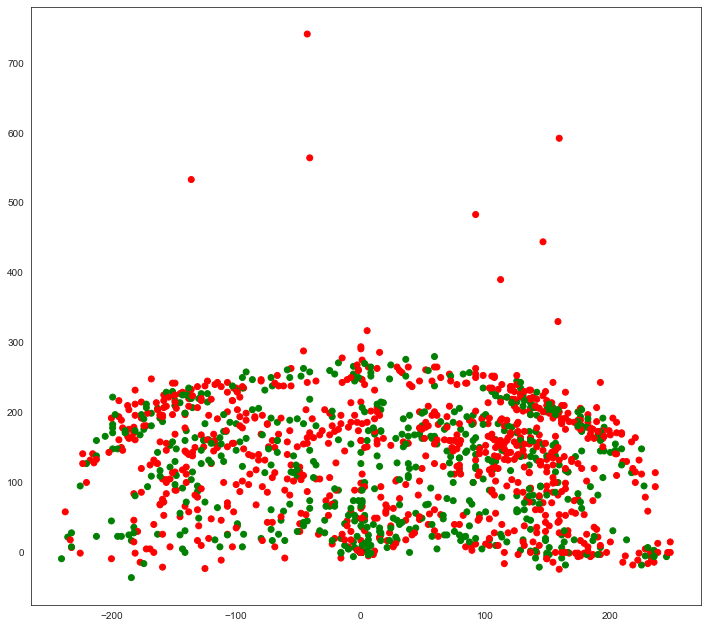

In [18]:
sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(12,11))
colors = {'Made Shot':'green', 'Missed Shot':'red'}
plt.scatter(kobe_2008_shots_df.LOC_X, kobe_2008_shots_df.LOC_Y, c=kobe_2008_shots_df.EVENT_TYPE.map(colors))
plt.show()

Note: The plot above represents an inversion of the data where the x-axis values are not on the correct side of the court. We can plot only shots in the "Right Side(R)" shot zone area to see the inversion. The plot below demonstrates how shots categorized as taken from the "Right Side(R)", while to the viewers right, are actually to the left side of the hoop. This is something we will need to fix when creating our final shot chart.

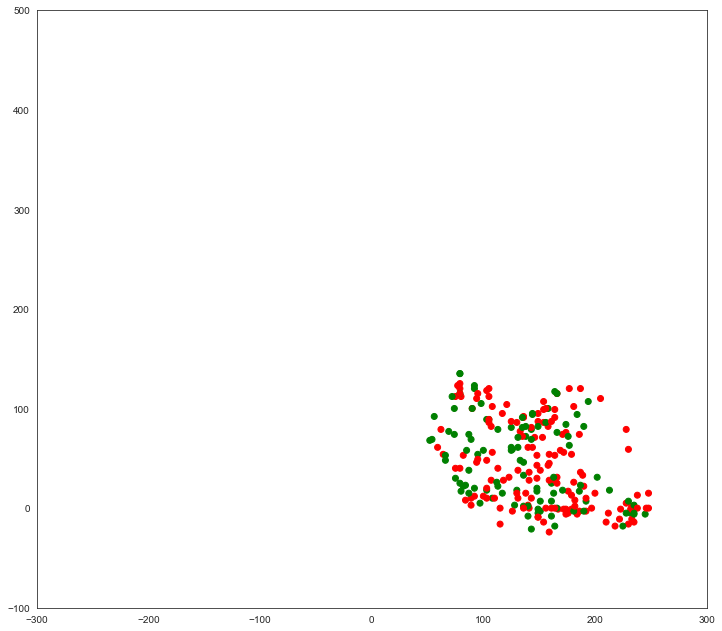

In [19]:
right = kobe_2008_shots_df.loc[kobe_2008_shots_df["SHOT_ZONE_AREA"] == "Right Side(R)"]
plt.figure(figsize=(12,11))
colors = {'Made Shot':'green', 'Missed Shot':'red'}
plt.scatter(right.LOC_X, right.LOC_Y, c=right.EVENT_TYPE.map(colors))
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

To draw our court, we can roughly estimate that the center of the hoop is at the origin (0,0) of the Cartesian grid. We can also estimate that every 10 units on either the X and Y axes represents one foot. We can verify this by just look at observations in our `shot_chart` DataFrame. The shot range for the first shot is characerized as "Less Than 8 ft.", the shot appears to be taken at the basket with the `LOC_Y` equal to 0. The second shot is categorized as "16-24 ft. " and the `LOC_Y` value is 201 suggested that every ten units equats to one feet (the shot appears to be taken 20 feet from the basket).

The dimensions of a basketball court can be seen [here](https://official.nba.com/rule-no-1-court-dimensions-equipment/)


Faye used the court dimensions along with `matplotlib` objects such as  Circle, Rectangle, and Arc objects to draw our court. The function `draw_court` encapsualtes all the court spatial knowledge and visual represenations

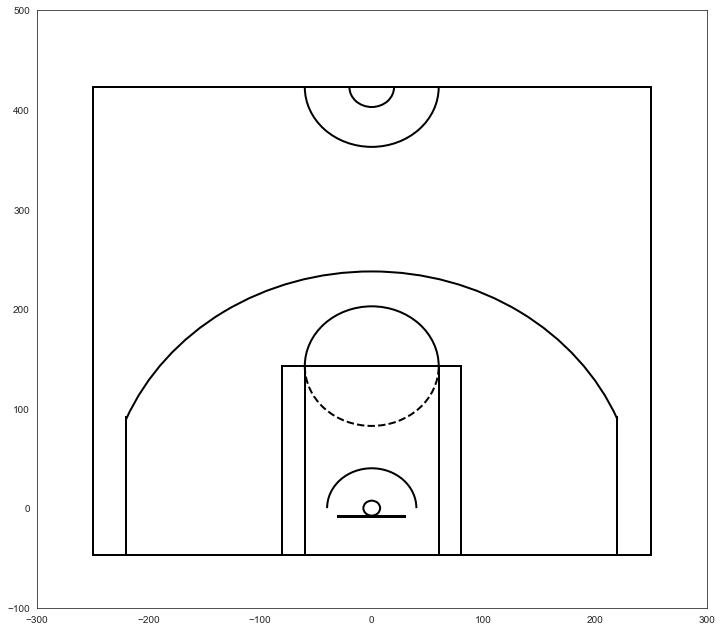

In [20]:
plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.show()

our next step is to overlay the scatter plot of shot location on the NBA court. when we overlay the NBA court, we can see that the furthest shots Kobe attempted were beyond half court and likely desperation heaves at the end of the quarter (we can confirm by inspecting further)

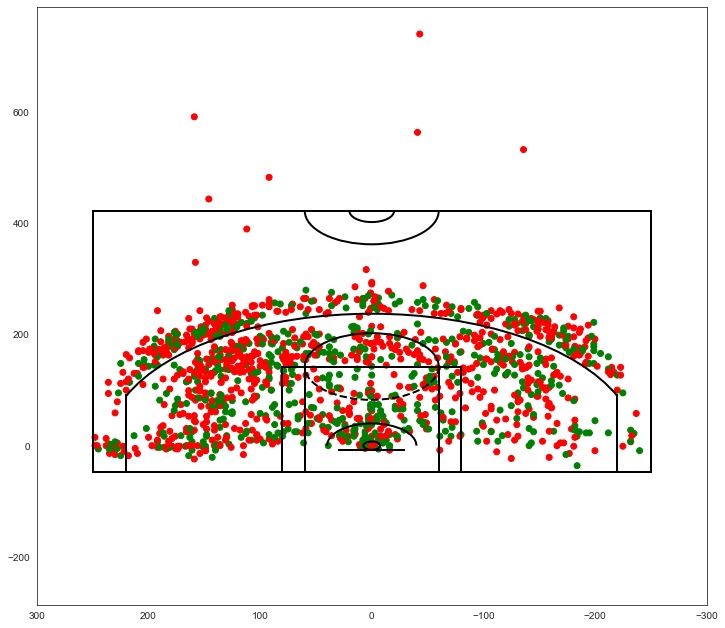

In [21]:
plt.figure(figsize=(12,11))
colors = {'Made Shot':'green', 'Missed Shot':'red'}
plt.scatter(kobe_2008_shots_df.LOC_X, kobe_2008_shots_df.LOC_Y, c=kobe_2008_shots_df.EVENT_TYPE.map(colors))
draw_court(outer_lines=True)
# Descending values along the axis from left to right
plt.xlim(300,-300)
plt.show()

Lets orient our shot chart with the hoop by the top of the chart, which is the same orientation as the shot charts on stats.nba.com. We do this by settting descending y-values from the bottom to the top of the y-axis. When we do this we no longer need to adjust the x-values of our plot.

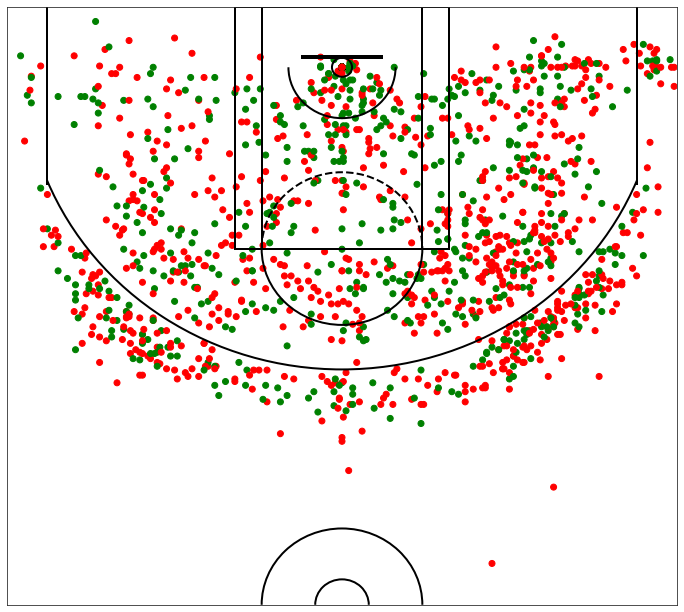

In [22]:
plt.figure(figsize=(12,11))
colors = {'Made Shot':'green', 'Missed Shot':'red'}
plt.scatter(kobe_2008_shots_df.LOC_X, kobe_2008_shots_df.LOC_Y, c=kobe_2008_shots_df.EVENT_TYPE.map(colors))
draw_court()
# Adjust plot limits to just fit in half court
plt.xlim(-250,250)
# Descending values along th y axis from bottom to top
# in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)
# get rid of axis tick labels
plt.tick_params(labelbottom=False, labelleft=False)
plt.show()

Lets start creating a version 1 of Goldsberry's shot charts using the `jointplot` function  from `seaborn`. `jointplot` adds a frequency dimension to the shot locations and is the first step to adding spatial analytics to our shot chart

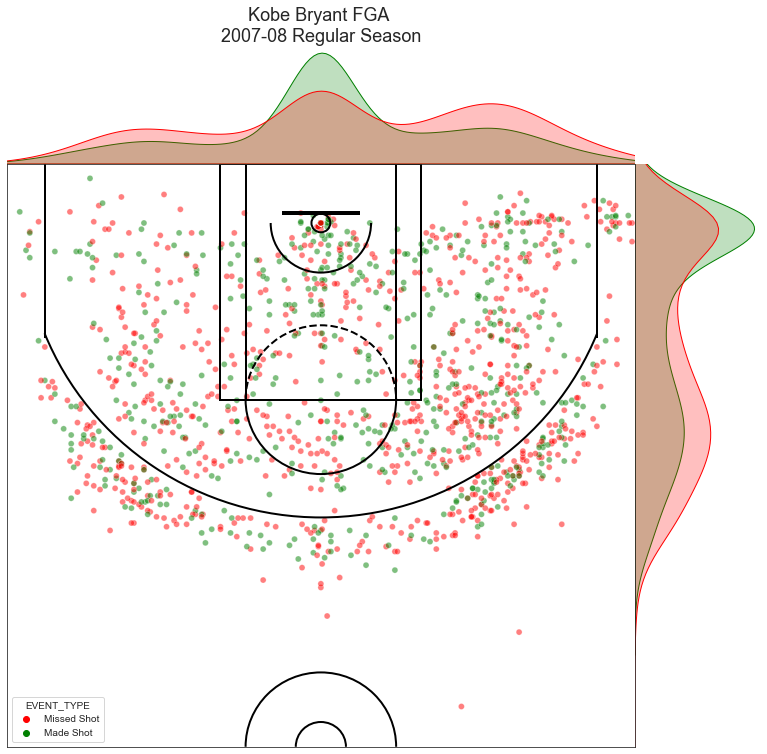

In [23]:
# create our jointplot
joint_shot_chart = sns.jointplot(x=kobe_2008_shots_df.LOC_X, y=kobe_2008_shots_df.LOC_Y, 
                                 hue=kobe_2008_shots_df.EVENT_TYPE,
                                 palette=['red', 'green'],
                                 kind='scatter', space=0, alpha=0.5)

joint_shot_chart.fig.set_size_inches(12,11)

# A joint plot has 3 Axes, 
# the first one called ax_joint is the one we want to draw our court onto and adjust some other settings
ax = joint_shot_chart.ax_joint
draw_court(ax)

# Adjust the axis limits and orientation of the plot in order  to plot half court
# with the hoop by the top of the plot
ax.set_xlim(-250,250)
ax.set_ylim(422.5, -47.5)

# Get rid of axis labels and tick marks
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels('')
ax.set_yticklabels('')

# Add a title
ax.set_title(f'Kobe Bryant FGA \n2007-08 Regular Season', 
             y=1.2, fontsize=18)

plt.show()

we can further customize this V1 shot chart by adding an image of the player, using the player `id` that we first retrieved from the NBA player database, we can use the `get_player_pic` function to retrieve a player's pic from the nba.com

In [24]:
def get_player_pic(player_id):
    # we pass in the link to the image as the 1st argument
    # the 2nd argument tells urlretrieve what we want to scrape
    player_pic_address = urllib.request.urlretrieve(f"http://stats.nba.com/media/players/230x185/{player_id}.png",
                                "{player_id}.png")
    # urlretrieve returns a tuple with our image as the first 
    # element and imread reads in the image as a 
    # mutlidimensional numpy array so matplotlib can plot it
    player_pic = plt.imread(player_pic_address[0])
    return(player_pic)

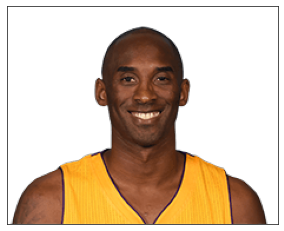

In [25]:
kobe_player_pic = get_player_pic(kobe_bryant_dict.get("id"))
plt.imshow(kobe_player_pic)
plt.tick_params(labelbottom=False, labelleft=False)
plt.show()

now let's add our player image to the V1 of the shot chart

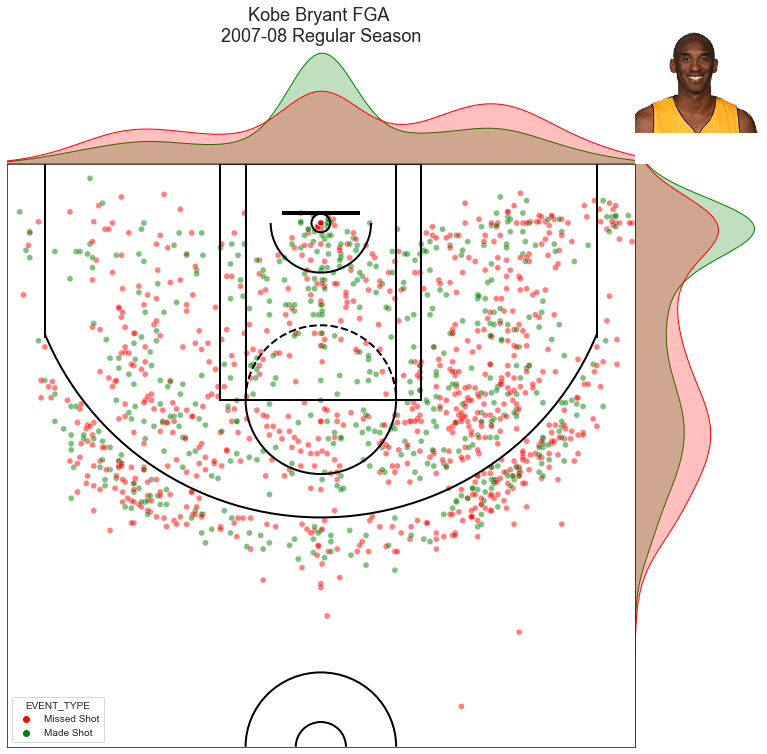

In [26]:
# create our jointplot
joint_shot_chart_2008 = sns.jointplot(x=kobe_2008_shots_df.LOC_X,
                                      y=kobe_2008_shots_df.LOC_Y, 
                                      hue=kobe_2008_shots_df.EVENT_TYPE,
                                      palette=['red', 'green'],
                                      kind='scatter', space=0, alpha=0.5)

joint_shot_chart_2008.fig.set_size_inches(12,11)

# A joint plot has 3 Axes, 
# the first one called ax_joint is the one we want to draw our court onto and adjust some other settings
ax = joint_shot_chart.ax_joint
draw_court(ax)

# Adjust the axis limits and orientation of the plot in order  to plot half court
# with the hoop by the top of the plot
ax.set_xlim(-250,250)
ax.set_ylim(422.5, -47.5)

# Get rid of axis labels and tick marks
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels('')
ax.set_yticklabels('')

# Add a title
ax.set_title('Kobe Bryant FGA \n2007-08 Regular Season', 
             y=1.2, fontsize=18)

# Add Kobe's image to the top right
# First create our OffSetImage by passing in our image
# and set the zoom level to make the image small enough to fit on our plot
img = OffsetImage(kobe_player_pic, zoom=0.6)
# Pass in a tuple of x,y coordinates to set_offset
img.set_offset((625,621))
# add the image
ax.add_artist(img)

plt.show()

* the function `create_joint_shot_chart` wraps the previous code into a function with the inputs for
    + shot dataframe
    + plot title
    + picture dictionary: optional, defaults to empty dictionary
        + otherwise enter dictionary with keys for include_pic and player_pic
* let's create a `jointplot` for Kobe's 2016 season using the `create_joint_shot_chart` and compare with his 2008 season.

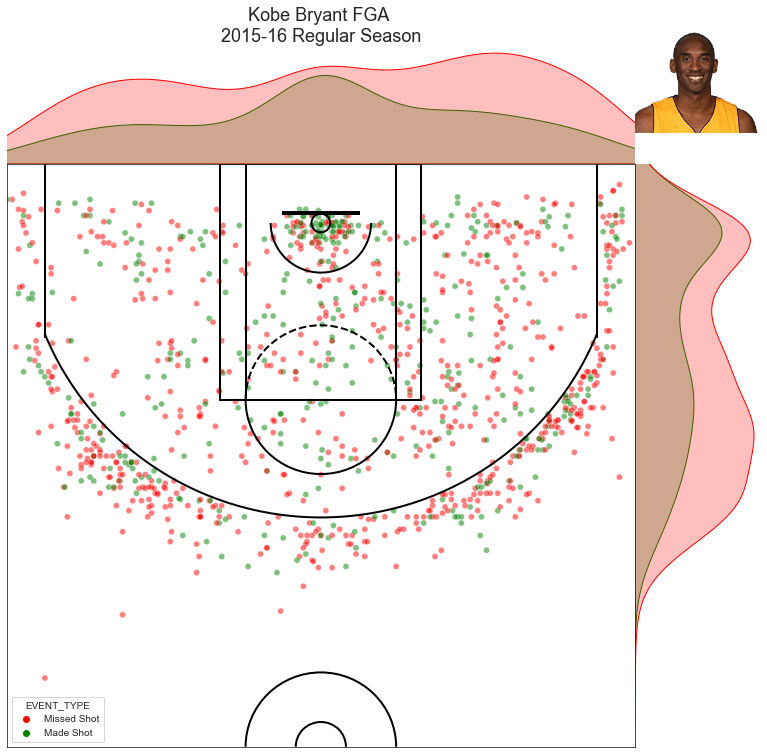

In [27]:
joint_shot_chart_2016 = create_joint_shot_chart(kobe_2016_shots_df,  "Kobe Bryant FGA \n2015-16 Regular Season", {"include_pic":True, 'player_pic': kobe_player_pic})
plt.show(joint_shot_chart_2016)

* we can remove Kobe's picture by dropping the optional argument for the player's picture dictionary

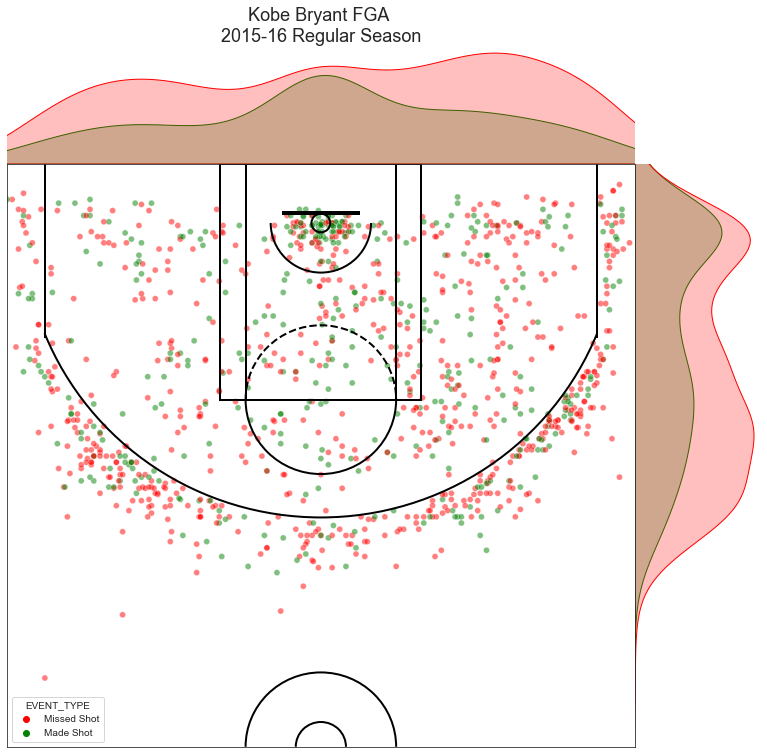

In [28]:
joint_shot_chart_2016 = create_joint_shot_chart(kobe_2016_shots_df,  "Kobe Bryant FGA \n2015-16 Regular Season")
plt.show(joint_shot_chart_2016)

## Review
Some interesting takeaways from the histograms provided by the `jointplot` function. Looking at the side-by-side plot of Kobe's shooting performance (below)
* we can see the frequency and efficiency that Kobe attacked the restricted area in his MVP season. 
    + Kobe made more field goals than he missed from 0-4 ft from the basket, a feat usually reserved for NBA "bigs" (individuals playing the Center or Power Forward possition)
* conversely, we see the decline in Kobe's efficiency his final year where there was no area where he made more field goals than he missed    
* Kobe also shot more from the right side of the court than the left, not surprising for a right-handed player
* the incredible spread and verstality in shot selection, Kobe shot from everywhere in both years shown
    + V2 of the shot chart will let us know how efficiently he shot relative to other areas on the court
    
In Part 2 of this series, we will modularize aspects of this notebook including getting shot chart data and begin applying Goldsberry's spatial analytics contributions

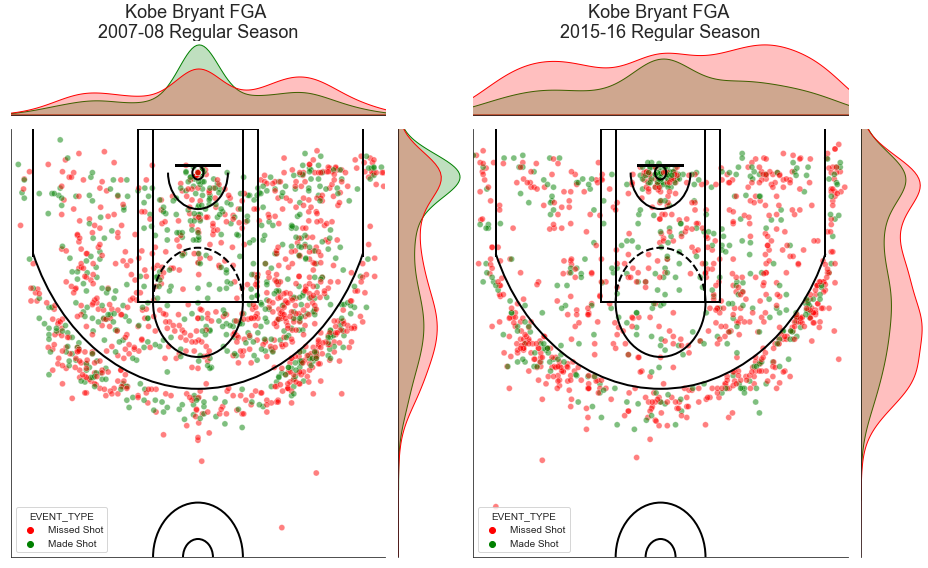

In [29]:
fig = plt.figure(figsize=(13,8))
fig.subplots_adjust(top=0.95) # Reduce plot to make room
gs = gridspec.GridSpec(1, 2)

mg0 = SeabornFig2Grid(joint_shot_chart, fig, gs[0])
mg1 = SeabornFig2Grid(joint_shot_chart_2016, fig, gs[1])

gs.tight_layout(fig)

In [30]:
import sys
import IPython
import matplotlib as mpl
from datetime import datetime
print('originally published 2022-02-27 16:20:00')
print(f'last updated: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")} \n')
print(f'Python version: {sys.version_info}')
print(f'matplotlib version: {mpl.__version__}')
print(f'iPython version: {IPython.__version__}')
print(f'urllib version: {urllib.request.__version__}')
print(f'seaborn version: {sns.__version__}')
print(f'pandas version: {pd.__version__}')

originally published 2022-02-27 16:20:00
last updated: 2022-03-01 17:54:18 

Python version: sys.version_info(major=3, minor=9, micro=7, releaselevel='final', serial=0)
matplotlib version: 3.4.3
iPython version: 7.29.0
urllib version: 3.9
seaborn version: 0.11.2
pandas version: 1.4.1


## References
* http://savvastjortjoglou.com/nba-shot-sharts.html
* https://github.com/bradleyfay/py-Goldsberry/